In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

!pip install keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

from sklearn.metrics import classification_report

Using Tensorflow version: 2.4.1


In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


## Predicting cellType

### Prepare train, test, validation dataset

In [11]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
Y = main_data['cellType']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=99)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.25, random_state=99)

trainY = trainY.ravel()
testY = testY.ravel()
valY = valY.ravel()

In [20]:
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(5937,)
(5937,)
(1979,)
(1979,)
(1980,)
(1980,)


In [21]:
trainX_img_list = trainX.tolist()
testX_img_list = testX.tolist()
valX_img_list = valX.tolist()

In [22]:
def create_img_dataset(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [23]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
# Khang desktop: C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images
# Khang laptop: C:\Users\Laptop\Desktop\RMIT\Cloud-GitHub\Minh\ML\Asm\ASM2\patch_images
path = r"C:\Users\Laptop\Desktop\RMIT\Cloud-GitHub\Minh\ML\Asm\ASM2\patch_images"

trainX_img = create_img_dataset(path, trainX_img_list)
testX_img = create_img_dataset(path, testX_img_list)
valX_img = create_img_dataset(path, valX_img_list)

Extracting Image Progress:  24%|██▍       | 475/1980 [00:00<00:00, 4715.60it/s]

Successfully import images!


Extracting Image Progress:  24%|██▍       | 483/1979 [00:00<00:00, 4795.01it/s]

Successfully import images!


Extracting Image Progress: 100%|██████████| 1979/1979 [00:00<00:00, 4313.70it/s]

Successfully import images!


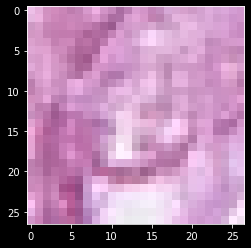

In [24]:
plt.imshow(trainX_img[0])

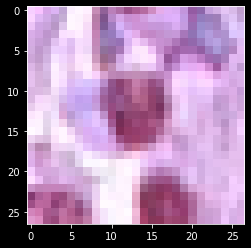

In [25]:
plt.imshow(testX_img[0])

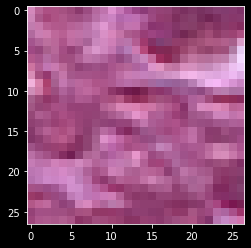

In [26]:
plt.imshow(valX_img[0])

### Build model

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=trainX_img.shape[1:], activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.2))

## Simple CNN

In [28]:
model = Sequential()
model.add(Conv2D(32,3,padding='same', activation='relu', input_shape=trainX_img.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation="softmax"))

model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 64)         

In [29]:
epochs = 100

history = model.fit(trainX_img, trainY,epochs = epochs , validation_data = (valX_img, valY))

Epoch 1/100
186/186 [==============================] - 7s 33ms/step - loss: 1.2815 - accuracy: 0.4220 - val_loss: 0.9374 - val_accuracy: 0.6422
Epoch 2/100
186/186 [==============================] - 7s 35ms/step - loss: 0.8940 - accuracy: 0.6497 - val_loss: 0.7360 - val_accuracy: 0.7079
Epoch 3/100
186/186 [==============================] - 5s 28ms/step - loss: 0.7879 - accuracy: 0.6893 - val_loss: 0.7348 - val_accuracy: 0.7009
Epoch 4/100
186/186 [==============================] - 5s 28ms/step - loss: 0.7208 - accuracy: 0.7208 - val_loss: 0.7752 - val_accuracy: 0.6958
Epoch 5/100
186/186 [==============================] - 5s 29ms/step - loss: 0.6778 - accuracy: 0.7394 - val_loss: 0.6596 - val_accuracy: 0.7398
Epoch 6/100
186/186 [==============================] - 5s 28ms/step - loss: 0.6696 - accuracy: 0.7351 - val_loss: 0.6989 - val_accuracy: 0.7246
Epoch 7/100
186/186 [==============================] - 5s 28ms/step - loss: 0.6695 - accuracy: 0.7357 - val_loss: 0.6899 - val_accuracy:

186/186 [==============================] - 5s 29ms/step - loss: 0.1858 - accuracy: 0.9317 - val_loss: 0.9014 - val_accuracy: 0.7514
Epoch 58/100
186/186 [==============================] - 5s 27ms/step - loss: 0.1861 - accuracy: 0.9296 - val_loss: 0.9542 - val_accuracy: 0.7595
Epoch 59/100
186/186 [==============================] - 5s 27ms/step - loss: 0.1661 - accuracy: 0.9388 - val_loss: 1.0034 - val_accuracy: 0.7610
Epoch 60/100
186/186 [==============================] - 5s 30ms/step - loss: 0.1799 - accuracy: 0.9344 - val_loss: 0.8591 - val_accuracy: 0.7605
Epoch 61/100
186/186 [==============================] - 5s 27ms/step - loss: 0.1662 - accuracy: 0.9415 - val_loss: 0.9021 - val_accuracy: 0.7645
Epoch 62/100
186/186 [==============================] - 5s 28ms/step - loss: 0.1534 - accuracy: 0.9411 - val_loss: 1.0207 - val_accuracy: 0.7393
Epoch 63/100
186/186 [==============================] - 5s 30ms/step - loss: 0.1656 - accuracy: 0.9358 - val_loss: 0.9505 - val_accuracy: 0.754

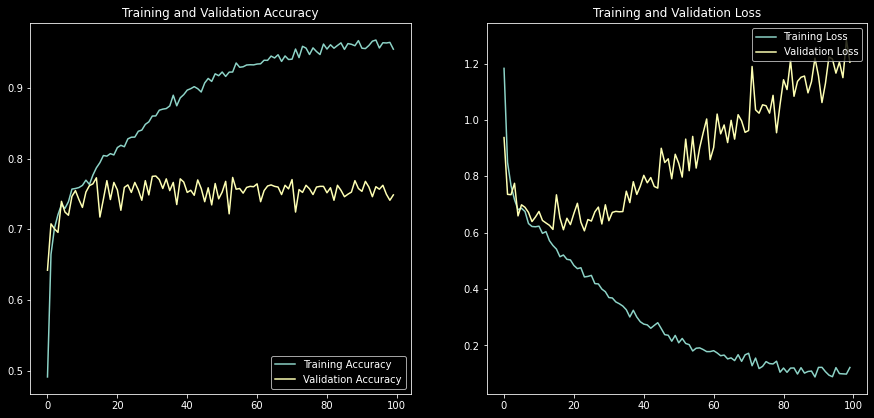

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
predictions = model.predict_classes(testX_img)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(testY, predictions, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 0       0.80      0.59      0.68       391
     Class 1       0.67      0.83      0.74       491
     Class 2       0.84      0.91      0.87       802
     Class 3       0.61      0.45      0.52       296

    accuracy                           0.76      1980
   macro avg       0.73      0.69      0.70      1980
weighted avg       0.76      0.76      0.75      1980

